
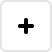
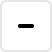
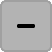
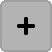
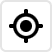
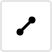
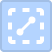
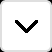
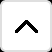
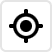
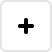
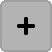
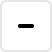
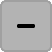
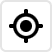
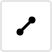
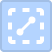
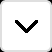
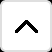
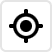

In [1]:
import contextlib
import ctypes
import io
import numpy as np
import os
import pandas as pd
import re
import sys
import tempfile
from IPython.display import Image
from lets_plot import *

LetsPlot.setup_html()

variant = "release"

MVG_EXPORT_DATA = []


# best-effort: flush all C stdio buffers
try:
    _libc = ctypes.CDLL(None)
    _fflush_all = lambda: _libc.fflush(None)
except Exception:
    _fflush_all = lambda: None


def capture_c_output(fn, *args, **kwargs) -> str:
    """
    Run fn(*args, **kwargs) and capture anything written to C stdout/stderr.
    Returns a single string with stdout followed by stderr.
    """
    # Flush Python and C buffers before swapping FDs
    sys.stdout.flush(); sys.stderr.flush(); _fflush_all()

    # Duplicate current stdout/stderr FDs
    old_out_fd = os.dup(1)
    old_err_fd = os.dup(2)

    with tempfile.TemporaryFile() as tmp_out, tempfile.TemporaryFile() as tmp_err:
        try:
            # Redirect FD 1 and 2 to our temp files
            os.dup2(tmp_out.fileno(), 1)
            os.dup2(tmp_err.fileno(), 2)

            # Run the function (which may call into C)
            fn(*args, **kwargs)

            # Flush again before restoring
            sys.stdout.flush(); sys.stderr.flush(); _fflush_all()
        finally:
            # Restore original FDs
            os.dup2(old_out_fd, 1)
            os.dup2(old_err_fd, 2)
            os.close(old_out_fd)
            os.close(old_err_fd)

        # Read captured data
        tmp_out.seek(0); tmp_err.seek(0)
        out = tmp_out.read().decode("utf-8", errors="replace")
        err = tmp_err.read().decode("utf-8", errors="replace")

    return out + err
    

def _parse_and_store_output(output_text, file_name, n, solid, scale, void):
    """
    Helper function to parse output, including timestamps with minutes,
    and append to the global data list.
    """
    
        
    def to_seconds(time_str):
        """
        Converts a complex time string (including minutes) into total seconds.
        This version correctly prioritizes specific units like 'ms' over 'm'.
        """
        if not time_str:
            return None
        time_str = time_str.strip()
    
        # --- Check for the most specific units FIRST ---
        if 'ms' in time_str:
            return float(time_str.replace('ms', '').strip()) / 1000
        if 'us' in time_str:
            return float(time_str.replace('us', '').strip()) / 1_000_000
        if 'ns' in time_str:
            return float(time_str.replace('ns', '').strip()) / 1_000_000_000
        
        # --- Now, check for the composite minute/second format ---
        if 'm' in time_str:
            total_seconds = 0
            parts = time_str.split('m')
            minutes = float(parts[0].strip())
            total_seconds += minutes * 60
            
            # If there's a seconds part after 'm', add it
            if len(parts) > 1 and parts[1].strip():
                seconds_str = parts[1].replace('s', '').strip()
                if seconds_str:
                    total_seconds += float(seconds_str)
            return total_seconds
    
        # --- Finally, check for standalone seconds ---
        if 's' in time_str:
            return float(time_str.replace('s', '').strip())
    
        # Fallback for unitless numbers (should not happen with this log format)
        try:
            return float(time_str)
        except ValueError:
            return None
    
              
        if 'ms' in time_str: return float(time_str.replace('ms', '')) / 1000
        if 'us' in time_str: return float(time_str.replace('us', '')) / 1_000_000
        if 'ns' in time_str: return float(time_str.replace('ns', '')) / 1_000_000_000
        if 's' in time_str: return float(time_str.replace('s', ''))
        
        try:
            return float(time_str)
        except ValueError:
            return None

    
    map_pattern = re.compile(r"(.+?): exportMvg\(\)\: plot mapped to canvas")
    paint_pattern = re.compile(r"(.+?): exportMvg\(\)\: plot painted")
    snapshot_pattern = re.compile(r"(.+?): exportMvg\(\)\: snapshot taken")
    
    map_match = map_pattern.search(output_text)
    paint_match = paint_pattern.search(output_text)
    snapshot_match = snapshot_pattern.search(output_text)

    mapping_time = to_seconds(map_match.group(1) if map_match else None)
    paint_time = to_seconds(paint_match.group(1) if paint_match else None)
    snapshot_time = to_seconds(snapshot_match.group(1) if snapshot_match else None)
    
    MVG_EXPORT_DATA.append({
        "file_name": file_name,
        "n": n,
        "solid": solid,
        "scale": scale,
        "void": void,
        "mapping_time": mapping_time,
        "paint_time": paint_time - mapping_time,
        "snapshot_time": snapshot_time - paint_time,
        "total_time": snapshot_time
    })
    

def save_mvg(ns, solid, scale, void=False):
    """
    Saves plots and automatically captures and parses the ggsave output
    by capturing both stdout and stderr.
    """

    # show demo plot
    p_n(100, solid, void).show()
    
    i = 1
    
    for n in ns:
        if solid:
            name = "solid_" + str(n)
        else:
            name = "stroked_" + str(n)

        p = p_n(n, solid, void)

        file_name = f"{name}@{scale}x.mvg" if scale != 1 else f"{name}.mvg"

        captured_output = capture_c_output(ggsave, p, file_name, scale=scale)
        
        print(str(i) + " of " + str(len(ns)) + " (n=" + str(n) + ", solid=" + str(solid) + ", void=" + str(void) + ", scale=" + str(scale) + ")\n" + captured_output)
        
        _parse_and_store_output(captured_output, file_name, n, solid, scale, void)
        i = i + 1

def p_n(n, solid, void):
    np.random.seed(42)
    
    x = np.random.uniform(size=n)
    y = np.random.uniform(size=n)
    v = np.random.normal(size=n)
    
    p = ggplot({'x': x, 'y': y, 'v': v}, aes('x', 'y', fill='x'))
    
    if void:
        theme = theme_void()
        show_legend = False
    else:
        theme = geom_blank()
        show_legend = True

    if solid:
        l = geom_point(show_legend=show_legend)
    else:
        l = geom_point(shape=21, show_legend=show_legend)

    return p + l + theme



# Solid

In [2]:
save_mvg([1000, 5000, 10_000, 20_000, 50_000], solid=True, scale=1)

1 of 5 (n=1000, solid=True, void=False, scale=1)
73ns: exportMvg(): plotSpec parsed
21.239us: exportMvg(): exportParameters(dpi=96.0, scaleFactor=1.0, sizingPolicy=SizingPolicy(widthMode=FIXED, heightMode=FIXED, width=null, height=null))
6.862766ms: exportMvg(): plotCanvasFigure built, size=(600, 400)
80.095175ms: exportMvg(): plot mapped to canvas
81.084073ms: exportMvg(): canvas size: (600, 400), pixelDensity=1.0
92.989576ms: exportMvg(): plot painted
168.949128ms: exportMvg(): snapshot taken
173.132419ms: exportMvg(): bitmap extracted
175.868310ms: exportMvg(): MVG extracted, length=662048
176.369881ms: exportMvg(): resources disposed

2 of 5 (n=5000, solid=True, void=False, scale=1)
63ns: exportMvg(): plotSpec parsed
19.385us: exportMvg(): exportParameters(dpi=96.0, scaleFactor=1.0, sizingPolicy=SizingPolicy(widthMode=FIXED, heightMode=FIXED, width=null, height=null))
19.054648ms: exportMvg(): plotCanvasFigure built, size=(600, 400)
259.552380ms: exportMvg(): plot mapped to canvas


In [3]:
save_mvg([1000, 5000, 10_000, 20_000, 50_000], solid=True, scale=2)

1 of 5 (n=1000, solid=True, void=False, scale=2)
188ns: exportMvg(): plotSpec parsed
13.687us: exportMvg(): exportParameters(dpi=96.0, scaleFactor=2.0, sizingPolicy=SizingPolicy(widthMode=FIXED, heightMode=FIXED, width=null, height=null))
5.625411ms: exportMvg(): plotCanvasFigure built, size=(600, 400)
67.417490ms: exportMvg(): plot mapped to canvas
68.438934ms: exportMvg(): canvas size: (600, 400), pixelDensity=2.0
80.909455ms: exportMvg(): plot painted
246.291126ms: exportMvg(): snapshot taken
262.640731ms: exportMvg(): bitmap extracted
265.145152ms: exportMvg(): MVG extracted, length=662048
265.173933ms: exportMvg(): resources disposed

2 of 5 (n=5000, solid=True, void=False, scale=2)
56ns: exportMvg(): plotSpec parsed
14.356us: exportMvg(): exportParameters(dpi=96.0, scaleFactor=2.0, sizingPolicy=SizingPolicy(widthMode=FIXED, heightMode=FIXED, width=null, height=null))
16.270574ms: exportMvg(): plotCanvasFigure built, size=(600, 400)
224.968355ms: exportMvg(): plot mapped to canvas

# Stroked

In [4]:
save_mvg([1000, 5000, 10_000, 20_000, 50_000], solid=False, scale=1)

1 of 5 (n=1000, solid=False, void=False, scale=1)
237ns: exportMvg(): plotSpec parsed
15.031us: exportMvg(): exportParameters(dpi=96.0, scaleFactor=1.0, sizingPolicy=SizingPolicy(widthMode=FIXED, heightMode=FIXED, width=null, height=null))
6.318999ms: exportMvg(): plotCanvasFigure built, size=(600, 400)
68.376238ms: exportMvg(): plot mapped to canvas
68.683459ms: exportMvg(): canvas size: (600, 400), pixelDensity=1.0
91.010137ms: exportMvg(): plot painted
186.989941ms: exportMvg(): snapshot taken
191.208673ms: exportMvg(): bitmap extracted
196.288386ms: exportMvg(): MVG extracted, length=1310745
196.316263ms: exportMvg(): resources disposed

2 of 5 (n=5000, solid=False, void=False, scale=1)
60ns: exportMvg(): plotSpec parsed
15.382us: exportMvg(): exportParameters(dpi=96.0, scaleFactor=1.0, sizingPolicy=SizingPolicy(widthMode=FIXED, heightMode=FIXED, width=null, height=null))
19.467283ms: exportMvg(): plotCanvasFigure built, size=(600, 400)
231.350887ms: exportMvg(): plot mapped to can

In [5]:
save_mvg([1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10_000], solid=False, scale=2)

1 of 10 (n=1000, solid=False, void=False, scale=2)
194ns: exportMvg(): plotSpec parsed
14.634us: exportMvg(): exportParameters(dpi=96.0, scaleFactor=2.0, sizingPolicy=SizingPolicy(widthMode=FIXED, heightMode=FIXED, width=null, height=null))
6.210414ms: exportMvg(): plotCanvasFigure built, size=(600, 400)
67.310252ms: exportMvg(): plot mapped to canvas
68.336284ms: exportMvg(): canvas size: (600, 400), pixelDensity=2.0
90.316609ms: exportMvg(): plot painted
442.749978ms: exportMvg(): snapshot taken
459.276959ms: exportMvg(): bitmap extracted
464.405157ms: exportMvg(): MVG extracted, length=1310745
464.444979ms: exportMvg(): resources disposed

2 of 10 (n=2000, solid=False, void=False, scale=2)
108ns: exportMvg(): plotSpec parsed
15.854us: exportMvg(): exportParameters(dpi=96.0, scaleFactor=2.0, sizingPolicy=SizingPolicy(widthMode=FIXED, heightMode=FIXED, width=null, height=null))
9.482904ms: exportMvg(): plotCanvasFigure built, size=(600, 400)
106.369766ms: exportMvg(): plot mapped to c

# Summary

In [6]:
# 3. Convert the global data list to a pandas DataFrame
results_df = pd.DataFrame(MVG_EXPORT_DATA)

# 4. Display the DataFrame
print("\n--- Extracted Data ---")
print(results_df)


--- Extracted Data ---
               file_name      n  solid  scale   void  mapping_time  \
0         solid_1000.mvg   1000   True      1  False      0.080095   
1         solid_5000.mvg   5000   True      1  False      0.259552   
2        solid_10000.mvg  10000   True      1  False      0.541641   
3        solid_20000.mvg  20000   True      1  False      1.062872   
4        solid_50000.mvg  50000   True      1  False      8.916766   
5      solid_1000@2x.mvg   1000   True      2  False      0.067417   
6      solid_5000@2x.mvg   5000   True      2  False      0.224968   
7     solid_10000@2x.mvg  10000   True      2  False      0.490322   
8     solid_20000@2x.mvg  20000   True      2  False      1.047824   
9     solid_50000@2x.mvg  50000   True      2  False      2.675369   
10      stroked_1000.mvg   1000  False      1  False      0.068376   
11      stroked_5000.mvg   5000  False      1  False      0.231351   
12     stroked_10000.mvg  10000  False      1  False      0.698010

In [7]:
ggplot(results_df, aes(x='n', y='snapshot_time', color='solid')) + geom_line() + geom_point(tooltips='none') + facet_grid(x='scale')

In [8]:
results_df.to_csv("variant_release.csv", index=False)